In [ ]:
# hide
import sys
sys.path.append("..")

In [ ]:
# export
# default_exp widgets

In [ ]:
# export
from faimed3d.all import *
from fastai.callback.all import *

In [ ]:
from faimed3d.all import *
from torchvision.models.video import r3d_18

In [ ]:
#hide
mrnet_data = pd.read_csv('../../mri-spa/data/train_knee.csv')
std = tensor([173.06963,184.85706,197.57706,210.63336,225.09673,241.43134,260.64816,285.0106,320.0079,386.4354,562.08795])
percs = tensor([1,10,20,30,40,50,60,70,80,90,99,])


dls = ImageDataLoaders3D.from_df(mrnet_data, '/media/..',
                                 item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (16, 112, 112), perc_crop = True),
                                 batch_tfms = [*aug_transforms_3d(), RandomPerspective3D(112, p=0.1)],
                                 valid_col = 'is_valid',
                                 bs = 64, val_bs = 64)

learn = cnn_learner_3d(dls, 
                       r3d_18,  
                       model_dir='/home/bressekk/Documents/faimed3d/trashbin/', 
                       metrics = [accuracy, RocAucBinary()],
                       cbs = SaveModelCallback())
learn = learn.to_fp16()

Cleaning tmpdir.
removing 144 files from /tmp/faimed3d_metadata/
You can disable automatic cleanup of the tmpdir (e.g. when doing multiple sessions in parallel) with setting clean_tmpdir=False
No rescale method was used. This is not advisable due to high risk of exploding gradients. Falling back to mean scaling.


/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0030199517495930195)

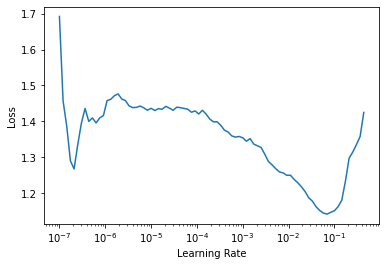

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 0.006)
learn = learn.load('model')

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.301131,0.952779,0.691667,0.572632,00:24
1,1.080610,1.367529,0.608333,0.696421,00:22
2,0.817241,0.672730,0.800000,0.763579,00:22
3,0.613403,0.522379,0.775000,0.758737,00:23
4,0.486030,0.511044,0.791667,0.775789,00:23


Better model found at epoch 0 with valid_loss value: 0.9527785181999207.
Better model found at epoch 2 with valid_loss value: 0.6727302670478821.
Better model found at epoch 3 with valid_loss value: 0.5223791003227234.
Better model found at epoch 4 with valid_loss value: 0.5110441446304321.


/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=6.309573450380412e-07)

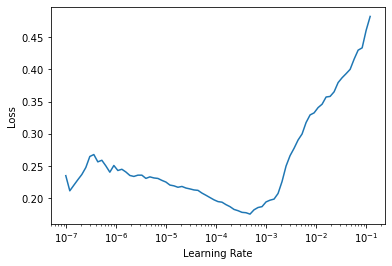

In [ ]:
learn = learn.load('model')
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 4.7e-5)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.216551,0.511865,0.808333,0.778105,00:34
1,0.173455,0.570048,0.775000,0.765053,00:34
2,0.143120,0.611926,0.775000,0.759579,00:34
3,0.121034,0.598863,0.775000,0.767158,00:35
4,0.100264,0.589259,0.775000,0.763789,00:34


Better model found at epoch 0 with valid_loss value: 0.5118650794029236.


In [ ]:
#learn.save('knee')
learn = learn.load('model')

In [ ]:
model = learn.model[-2][4]

In [ ]:
model.eval()

Sequential(
  (0): BasicBlock(
    (conv1): Sequential(
      (0): Conv3DSimple(256, 512, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv3DSimple(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv3d(256, 512, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
      (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Sequential(
      (0): Conv3DSimple(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
fn = mrnet_data.file_names[1]
img = TensorDicom3D.create(fn)

In [ ]:
learn.predict(img)

('1', tensor(1), tensor([0.0144, 0.9856]))

In [ ]:
x,  = first(dls.test_dl([img]))
x = torch.stack((x, )*3, 1)

Implement GradCams as HookCallback, allows calculation of GradCams on the fly during training and also Calling GradCam function on trained model. 

In [ ]:
class_Z = 1

with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]
    

w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
gradcam_map = Resize3D((16, 112, 112))(TensorDicom3D(gradcam_map))

In [ ]:
for c in learn.model.children():
    print(c)

Sequential(
  (0): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNor

In [ ]:
class GradCam():
    def __init__(self, model, **kwargs):
        target_layer = model[-2][-1]
        self.forward_hook = target_layer.register_forward_hook(self.hook_activation) 
        self.gradient_hook = target_layer.register_backward_hook(self.hook_gradient)  
        
    def __call__(self):
        
    
    
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()

    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.forward_hook.remove()   
        self.gradient_hook.remove()
        
    
        

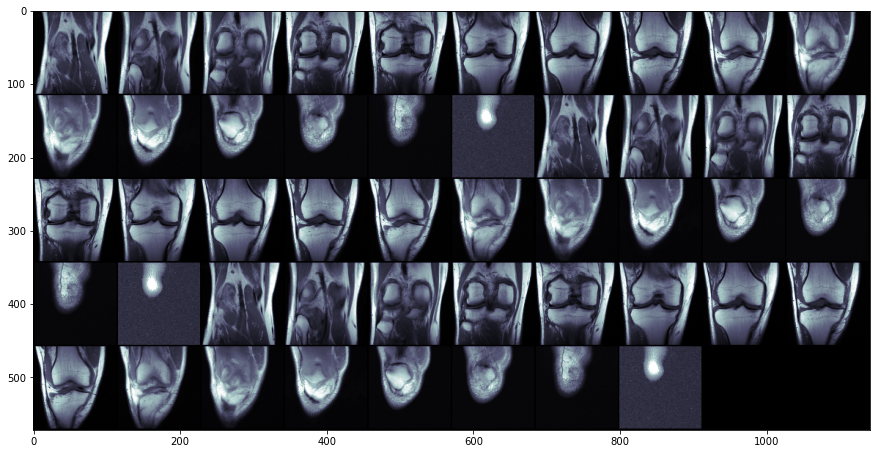

In [ ]:
x_img = TensorDicom3D(dls.train.decode((x,))[0][0])
x_img.show()

In [ ]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [ ]:
class_Z = 1
target_layer = model
with HookGradient(target_layer) as hookg:
    with HookActivation(target_layer) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0, class_Z].backward()
    grad = hookg.stored
    p0, p1 = output.cpu().detach()[0]

In [ ]:
w = grad[0].mean(dim=(1,2), keepdim=True)
gradcam_map = (w * act[0]).sum(0).detach().cpu()
gradcam_map = Resize3D((16, 112, 112))(TensorDicom3D(gradcam_map))

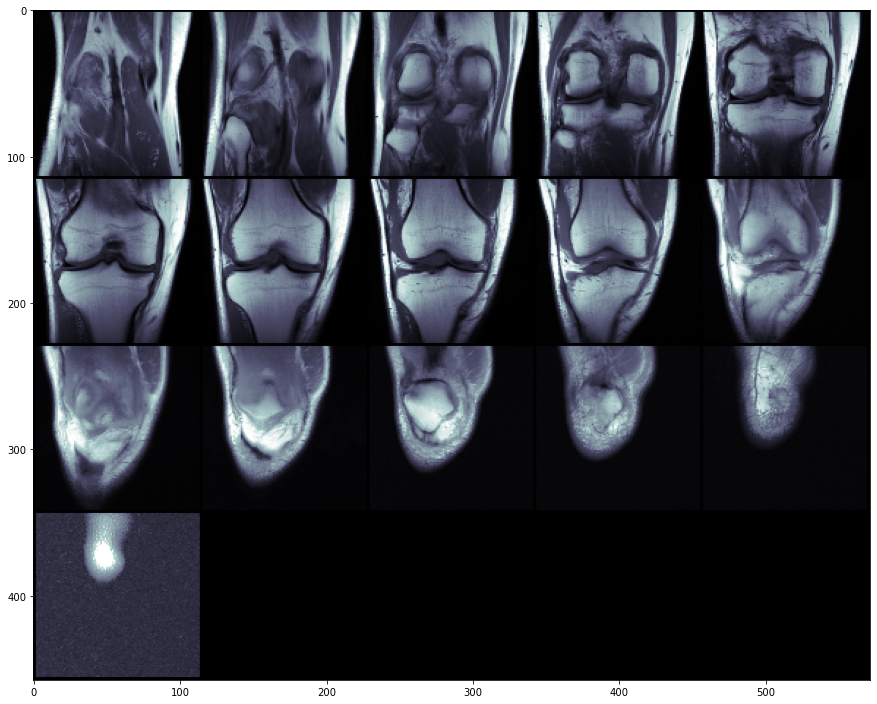

In [ ]:
x_img[0].show(nrow = 5)


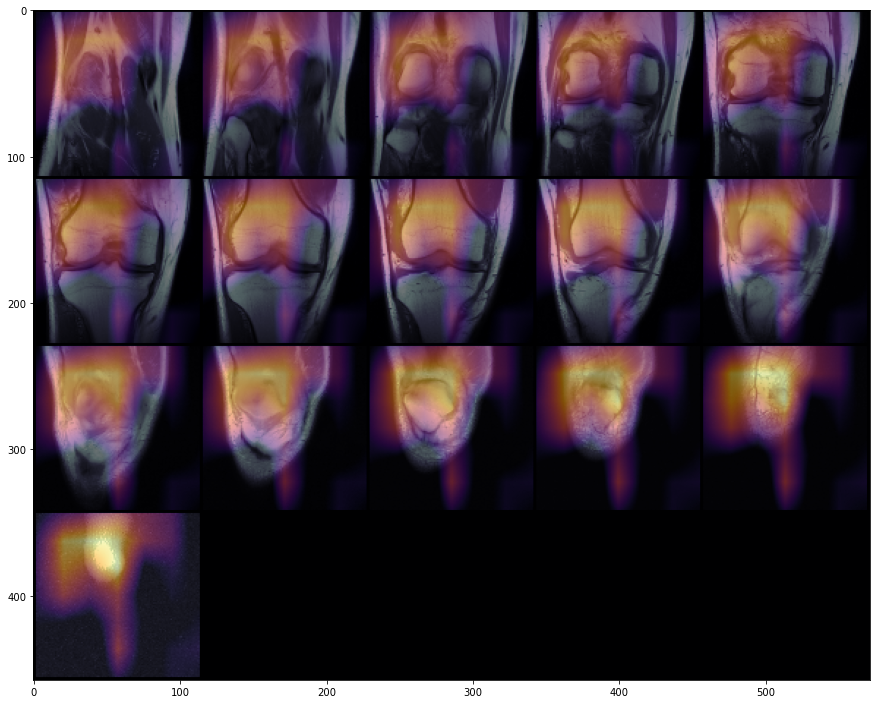

In [ ]:
x_img[0].show(nrow = 5)
gradcam_map.clamp(min=0).show(cmap='inferno', alpha = 0.5, add_to_existing = True, nrow = 5)

In [ ]:
class MetadataTensor(object):
    def __init__(self, data, metadata=None, **kwargs):
        self._t = torch.as_tensor(data, **kwargs)
        self._metadata = metadata

    def __repr__(self):
        return "Metadata:\n{}\n\ndata:\n{}".format(self._metadata, self._t)

    def __torch_function__(self, func, types, args=(), kwargs=None):
        if kwargs is None:
            kwargs = {}
        args = [a._t if hasattr(a, '_t') else a for a in args]
        ret = func(*args, **kwargs)
        return MetadataTensor(ret, metadata=self._metadata)
    
    def __getitem__(self, item: torch.Tensor):
        updated_value = self._t[item]
        return MetadataTensor(updated_value, self._metadata)

In [ ]:
metadata = {'faimed3d_type': 'TensorDiom3D'}
data = [[1, 2], [3, 4]]
m = MetadataTensor(data = data, metadata = metadata)
t = torch.tensor(data)

In [ ]:
m[0]

Metadata:
{'faimed3d_type': 'TensorDiom3D'}

data:
tensor([1, 2])